In [13]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
# Pkg.add("ForwardDiff")
# Pkg.add("RobotDynamics")
# Pkg.add("LinearAlgebra")
# Pkg.add("StaticArrays")
# Pkg.add("SparseArrays")
# Pkg.add("Plots")
# Pkg.add("Printf")
# Pkg.add("Ipopt")
# Pkg.add("MathOptInterface")
# Pkg.add("TrajOptPlots")
using ForwardDiff
using Test
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Plots
using Ipopt
using MathOptInterface
using TrajOptPlots
const MOI = MathOptInterface

# using PyPlots
using Printf

# include("quadratic_cost.jl")


 Activating environment at `F:\Documents\Schoolwork\optimalControl\16-745_final_project\Project.toml`
   Updating registry at `C:\Users\alexr\.julia\registries\General`
  Resolving package versions...
  Installed ASL_jll ──────────── v0.1.2+0
  Installed Ipopt_jll ────────── v3.13.4+2
  Installed BenchmarkTools ───── v0.7.0
  Installed MutableArithmetics ─ v0.2.18
  Installed MathOptInterface ─── v0.9.21
Updating `F:\Documents\Schoolwork\optimalControl\16-745_final_project\Project.toml`
  [b6b21f68] + Ipopt v0.6.5
Updating `F:\Documents\Schoolwork\optimalControl\16-745_final_project\Manifest.toml`
  [ae81ac8f] + ASL_jll v0.1.2+0
  [6e4b80f9] + BenchmarkTools v0.7.0
  [b99e7846] + BinaryProvider v0.5.10
  [523fee87] + CodecBzip2 v0.7.2
  [944b1d66] + CodecZlib v0.7.0
  [b6b21f68] + Ipopt v0.6.5
  [9cc047cb] + Ipopt_jll v3.13.4+2
  [7d188eb4] + JSONSchema v0.3.3
  [d00139f3] + METIS_jll v5.1.0+5
  [d7ed1dd3] + MUMPS_seq_jll v5.2.1+4
  [b8f27783] + MathOptInterface v0.9.21
  [fdba3010] + 

# Final Project Info
In this we present a geostationary transfer orbit to a geosynchronous (GSO) or geostationary orbit (GEO).  We use Keplerian Orbital Dynamics to model our system. We make several assumptions like Earth Reference Frame, Spherical Earth, Kepler Dynamics. 

## The Model
We'll be using the Kepler Dynamics:

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

$$ 
\ddot{r} = F = \frac{-\mu}{\norm{r}^3}*r+u \\
x = [r, \dot{r}] \\
\norm{u} \le Tmax
$$
with the following model parameters:
* $\mu$: Gravitational Parameter = 63781
* $r$: distance to earth center
* $u$: control of ion thruster

In [14]:
# Problem Setup
# Dont want KM and S
# Rescale unite to order 1
# Length unit = SMA 
# Time scale = T orbit period
# Helps condition number 

Nx = 6 
Nu = 3

# Hint can take big steps 10 knot points per-orbit
# model = Kepler() # TODO
# n,m = size(model)          # state and control dimensions
# TODO FIX ME
dt = 0.025                 # time step (sec)
tf = 1.5                   # time horizon (sec)
T = Int(tf/dt) + 1         # number of time steps

# n_nlp = (Nx+Nu)*T # number of decision variables
# m_nlp = Nx*(T+1)

# Initial & final condition

#cartesian and ECI
#x,y,z,vx,vy,vz
earthRadius_km = 6378.1 # [km]
LEO_km = 500 #km above sealevel #circular low earth orbit # 250km 
GSO_km = 35786 #km above sealevel #circular geosychonous orbit
μ_km_s = 3.986*10e5 #gravitational0 parameter [km^3 / s^2]
semiMajorAxis_scale = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/2
period_scale = sqrt(semiMajorAxis_scale^3/μ_km_s)*2*pi
μ = μ_km_s*period_scale^2/semiMajorAxis_scale^3  #μ(OU^3/P^2)

struct Orbit{T}
    semiMajorAxis::T
    period::T
    perigee::T #closest radius to earth
    perigee_V::T #velocity at perigee
    x0::Vector{T}
#     function Orbit(x0) 
#         print(x0) #best is to input point with velocity and calucate useful parts of orbit
#     end
end

function make_orbit(x0)
    velocity = norm(x0[4:end])
    
    radius = norm(x0[1:3])
    
    semiMajorAxis = 1/(-velocity^2/μ+2/radius)  #reverse vis a viv
    
    period = sqrt(semiMajorAxis^3/μ)*2*pi       #period equation
    
    E = velocity^2/2 - μ/radius   #specific energy of satellite
    
    J = norm(cross(x0[1:3],x0[4:end]))           #specific momentum of satellite
    
    perigee = -μ/(2*E) - 1/2*sqrt(μ^2/(E^2)+2*J^2/E) #solve quadratic when velocity of radius is 0
    
    perigee_v =  sqrt(μ*(2.0/perigee-1.0/semiMajorAxis)) # Vis a Viv
    apogee  = -μ/(2*E) + 1/2(μ^2/(E^2)+2*J^2/E) #solve quadratic when velocity of radius is 0
    apogee_v =  sqrt(μ*(2.0/apogee-1.0/semiMajorAxis)) # Vis a Viv
    return Orbit(semiMajorAxis, period, perigee, perigee_v, x0)
end

make_orbit (generic function with 1 method)

In [15]:
# Geosynchronous Transfer orbit (starting position)
semiMajorAxis_transfer = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/(2*semiMajorAxis_scale) #OU
instantRadius_transfer = (earthRadius_km+LEO_km) / semiMajorAxis_scale # #OU
instantVelocity_transfer = sqrt(μ*(2.0/instantRadius_transfer-1.0/semiMajorAxis_transfer)) #sqrt(OU^3/P^2/OU) =OU/P
period_transfer = sqrt(semiMajorAxis_transfer^3/μ)*2*pi
x0    = [instantRadius_transfer, 0.0, 0.0, 0.0, instantVelocity_transfer, 0.0] # initial state #geosynchronous transfer orbit (GTO, where rocket dropped satellite off)
                                                                             #many kilometers above Africa in an elliptical orbit 
transfer_orbit = Orbit(semiMajorAxis_transfer, period_transfer, instantRadius_transfer, instantVelocity_transfer, x0)

Orbit{Float64}(1.0, 1.0, 0.28049720444841386, 15.556684458046954, [0.28049720444841386, 0.0, 0.0, 0.0, 15.556684458046954, 0.0])

In [16]:
# Geosynchronous Orbit (goal position)
semiMajorAxis_goal = 2*(earthRadius_km+GSO_km)/(2*semiMajorAxis_scale)
instantRadius_goal = (earthRadius_km+GSO_km) / semiMajorAxis_scale
instantVelocity_goal = sqrt(μ*(2.0/instantRadius_goal-1.0/semiMajorAxis_goal)) # VisViva
period_goal = sqrt(semiMajorAxis_goal^3/μ)*2*pi
xgoal = [instantRadius_goal, 0.0, 0.0, 0.0, instantVelocity_goal, 0.0] # goal state #circular geosychonous orbit above africa
goal_orbit = Orbit(semiMajorAxis_goal, period_goal, instantRadius_goal, instantVelocity_goal, xgoal)
ugto = zeros(3)                  # hover controls

# Cost matrices
# Q = #TODO  #Diagonal(SVector{6}([ones(3) ; fill(0.1, 3)]))
# R = #TODO  #Diagonal(@SVector fill(1e-2, m))
# Qf = #TODO #Diagonal(@SVector fill(1e2, n));

In [84]:
function cost(Z)
    X, U = unpackZ(Z)
   # U = Z[Nx+1:Nx+Nu, :]
    N = length(X[1,:])
    J = 0.0
    for k = 1:N-1
        J += norm(U[k])^2 + (norm(X[1:3, k])-goal_orbit.perigee)
    end 
    J += (norm(X[:,end]-xgoal))
    return J 
end

cost (generic function with 1 method)

In [85]:
cost(z)

78.3207092527272

## Dynamics

In [43]:
function dynamics(x, u)
    # x = state [x, y, z, dx, dy, dz]
    # u = control [ux, uy, uz]
    r = x[1:3] #orbital units (OU)
    ṙ = x[4:end] #
    r̈ = (-μ/(norm(r)^3))*r + u #μ(OU^3/P^2)/OU^3*OU
    return [ṙ; r̈]
end

dynamics (generic function with 1 method)

In [44]:
function integrator!(x, u, h)
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    x .+= (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

integrator! (generic function with 1 method)

In [45]:
function dynamics_rk4(x, u, h) # Maybe rk8 or more
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    return (x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
end

dynamics_rk4 (generic function with 1 method)

In [46]:
function get_energy(x)
    return norm(x[4:end])^2/2 - μ/norm(x[1:3])
end

get_energy (generic function with 1 method)

In [179]:
knots = 100
function plot_orbit(orbit::Orbit)
    t = range(0, orbit.period, length=knots) 
    h = t[2]-t[1]
    traj = zeros(size(t)[1], size(x0)[1])
    x = copy(orbit.x0)
    traj[1,:] .= x
    
    u = zeros(3)
    energy = zero(t)
    energy[1] = get_energy(x)
    for i in 2:size(t)[1]
        integrator!(x, u, h)
        traj[i,:] .= x
        energy[i] = get_energy(x)
        orbit = make_orbit(x)
    end
#     plot(t, energy)
    plot(traj[:, 1], traj[:, 2], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.5,semiMajorAxis_goal*1.5))
end

plot_orbit (generic function with 1 method)

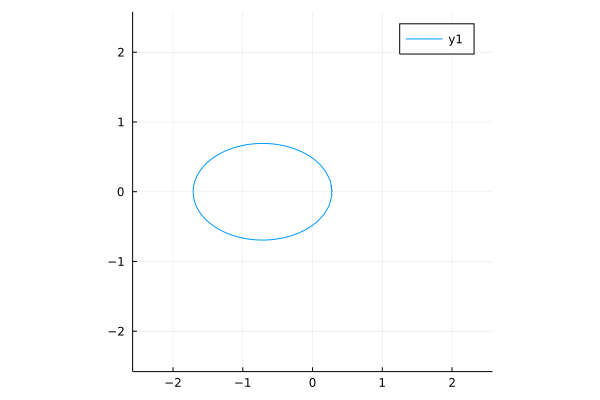

In [180]:
# plot(t, energy)
plot_orbit(transfer_orbit)

## Constraints

$ c = [c_{init}, c_{terminal}, c_{dynamics}, c_{thurst}] $

In [169]:
function unpackZ(ztraj)
    """
    Inputs: 
        ztraj -> Trajectory
    
    Returns: 
        xtraj -> state trajectory (Nx, T)
        utraj -> control trajectory (Nu, T-1)
    """
    Nt = knots
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = hcat(z[1:Nx,:], ztraj[end-(Nx-1):end])
    utraj = z[(Nx+1):(Nx+Nu),:]
    
    return xtraj, utraj
end

unpackZ (generic function with 1 method)

In [170]:
xx, uu = unpackZ(z)

([0.28049720444841386 -0.4023401522087323 … 0.0 1.7195027955515862; 0.2565343370719556 -0.47784765760548653 … 0.0 0.0; … ; 0.023944312827408762 -0.6847888944824929 … 0.0 4.791576488602332; -0.06639192890232598 -0.7477182766126014 … 0.0 0.0], [-0.15508746576659593 -0.807856397267677 … 0.0 0.0; -0.24090849307573006 -0.8653318820007574 … 0.0 0.0; -0.3233706438758429 -0.920263596137801 … 0.0 0.0])

In [171]:
size(xx)

(6, 100)

In [154]:
function dynamics_constraints!(nlp, c, ztraj)
    """
    Inputs: 
        c -> Constraint Vector: shape = 
        ztraj -> Current trajectory: shape ((Nx+Nu)*T, 1)
    
    Returns: 
        Nothing
    """
    h = 1/knots # dt? 
    X, U = unpackZ(ztraj)
    N = nlp.N

    d = reshape(view(c, nlp.idx_ineq[3]), Nx,(N-1))
    
    for k = 1:N-1
        d[:, k] .= dynamics_rk4(X[:,k], U[:,k], h) - X[:,k+1]
    end
    
    return d
end
    

dynamics_constraints! (generic function with 1 method)

In [155]:
function thrust_constraints!(nlp, c, ztraj)
    """
    Inputs: 
        c -> Constraint Vector: shape = 
        ztraj -> Current trajectory: shape ((Nx+Nu)*T, 1)
    
    Returns: 
        Nothing
    """
    N = nlp.N
    d = reshape(view(c, nlp.idx_ineq[4]), Nu,(N-1))#view(c, nlp.idx_ineq[end])#
    X, U = unpackZ(ztraj)
    
    for k = 1:N-1
        d[:,k] .= norm(U[:,k])
    end
    
    return d
end

thrust_constraints! (generic function with 1 method)

In [156]:
function con!(nlp, c, Z)
    X, U = unpackZ(Z)
    c[nlp.idx_ineq[1]] .= X[:,1] - x0 # Initial condition constraint
    c[nlp.idx_ineq[2]] .= X[:,end] - xgoal # Final condition constraint
    dynamics_constraints!(nlp, c, Z) # Dynamics constraints
    thrust_constraints!(nlp, c, Z) # Thrust constraints
end

con! (generic function with 1 method)

In [53]:
# # Define the NLP
# model = SimpleOrbit()
# nlp = OrbitNLP(model, transfer_orbit.period, 100, 0, x0, xgoal);

# @testset "Part c: Constraints" begin
#     Z = rand(num_primals(nlp))
#     X,U = unpackZ(nlp, Z)
#     c = zeros(num_duals(nlp))
#     n,m,N = size(nlp)

#     @testset "Dynamics constraints" begin
#         d = dynamics_constraints!(nlp, c, Z)
#         display(d)
#         @test length(d) == n*(N-1)
        
# #         @test d[1:n] ≈ stance1_dynamics_rk4(model, X[1], U[1], dt) - X[2]
# #         @test d[n*(M-1) .+ (1:n)] ≈ jump2_map(stance1_dynamics_rk4(model, X[M], U[M], dt)) - X[M+1]
# #         @test d[n*M .+ (1:n)] ≈ stance2_dynamics_rk4(model, X[M+1], U[M+1], dt) - X[M+2]
#     end

#     @testset "Thrust constraints" begin
#         d = thrust_constraints!(nlp, c, Z)
#         display(d)
#         @test length(d) == N-1
# #         @test d[1:M] ≈ [x[4] for x in X[1:M]]
# #         @test d[M .+ (1:M)] ≈ [x[6] for x in X[M .+ (1:M)]]
#     end

# #     @testset "Length constraints" begin
# #         d = length_constraint!(nlp, c, Z)
# #         @test length(d) == 2N
# #         @test d[1] ≈ norm(X[1][1:2] - X[1][3:4])
# #         @test d[2] ≈ norm(X[1][1:2] - X[1][5:6])
# #         @test d[3] ≈ norm(X[2][1:2] - X[2][3:4])
# #         @test d[4] ≈ norm(X[2][1:2] - X[2][5:6])
# #     end
# end;

## Part (a): Implement DIRCOL 
Implement DIRCOL by completing the provided methods. 

In [209]:
"""
    Problem{n,m,L}

Describes a trajectory optimization problem with `n` states, `m` controls, and 
a model of type `L`. 

# Constructor
    Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

where `tf` is the final time, and `x0` is the initial state. 
"""
# struct Problem{n,m,L}
    # TODO 
# end
# Base.size(prob::Problem{n,m}) where {n,m} = (n,m,prob.T)

struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    N::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp, N;
        idx_ineq=get_cinds(Nx, N),
        m_nlp = idx_ineq[end][end],
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        N, # Nt
        idx_ineq, # Indexes
        obj_grad, 
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function get_cinds(n, N)
    c_init_inds = 1:Nx
    c_term_inds = (c_init_inds[end]+1):(c_init_inds[end]+Nx)
    c_dyn_inds = (c_term_inds[end]+1):(c_term_inds[end]+((Nx)*(N-1)))
    c_thrust_inds = (c_dyn_inds[end]+1):(c_dyn_inds[end]+(Nu*(N-1)))
    
    return [c_init_inds, c_term_inds, c_dyn_inds, c_thrust_inds]
end

function constraint_bounds(m_nlp; idx_ineq)
    lb = zeros(m_nlp) 
    lb[idx_ineq[1]] .= 0 ##x0
    lb[idx_ineq[2]] .= 0 #xf
    lb[idx_ineq[3]] .= 0
    lb[idx_ineq[4]] .= 0 # Might have a minimum thrust requirment

    ub = zeros(m_nlp) #fill(-Inf,m_nlp)
    ub[idx_ineq[1]] .= 0 #x0
    ub[idx_ineq[2]] .= 0 #xf
    ub[idx_ineq[3]] .= 0
    ub[idx_ineq[4]] .= Inf

    return lb, ub
end

function row_col!(row,col,r,c)
    println("starting row_col")
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    println("Finished row_col")
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(prob, g, x) # TODO: Implement con! (Mitch)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), (c,x) -> con!(prob, c, x), zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

# TODO: Confirm meaning of these functions
MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = vec(Tuple.(CartesianIndices(zeros(m_nlp, n_nlp))))#prob.sparsity_jac#



function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=100)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

11×6 Adjoint{Float64,Array{Float64,2}}:
 -1.68964   0.14379     0.0  -0.771266  -2.51644   0.0
 -1.69667   0.118571    0.0  -0.634808  -2.52701   0.0
 -1.70233   0.0932572   0.0  -0.498938  -2.53548   0.0
 -1.70665   0.0678687   0.0  -0.363529  -2.54188   0.0
 -1.70961   0.0424263   0.0  -0.228455  -2.54624   0.0
 -1.7195   -0.0        -0.0  -0.0       -4.79158  -0.0
 -1.71611  -0.107968    0.0   0.300866  -4.78212   0.0
 -1.70594  -0.215511    0.0   0.600544  -4.75379   0.0
 -1.68905  -0.322203    0.0   0.897852  -4.7067    0.0
 -1.66548  -0.427623    0.0   1.19162   -4.64104   0.0
 -1.63534  -0.531356    0.0   1.48068   -4.55706   0.0

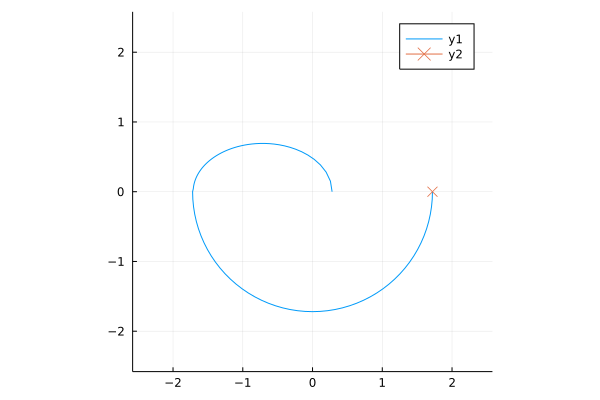

In [206]:
knots = 100
function impulse_ref_traj(init_orbit::Orbit,final_orbit::Orbit) #knots,Nx,Nu
    time = knots #Int(ceil(init_orbit.period/2*knots/2+final_orbit.period*knots))
    traj = zeros(time-1,Nx+Nu)
    x = copy(init_orbit.x0)
    u = zeros(Nu)
    traj[1,:] .= vcat(x,u)
    h = init_orbit.period/(knots)
    for i in 2:size(traj)[1]
        integrator!(x, u, h)
        if (i == Int(ceil(init_orbit.period/2*knots)))
            x = final_orbit.x0 .* -1
            h = final_orbit.period/(knots)
        end
        traj[i,:] .= vcat(x,u)
    end
    traj = reshape(traj',((time-1)*(Nx+Nu),1))
    traj = vcat(traj,final_orbit.x0)
    return traj
end
z = impulse_ref_traj(transfer_orbit,goal_orbit)
X,U = unpackZ(z)
transition = Int(ceil(transfer_orbit.period*knots/2))
display(X[:,transition-5:transition+5]')
plot(X[1, :], X[2, :], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.5,semiMajorAxis_goal*1.5))
plot!([goal_orbit.x0[1]], [goal_orbit.x0[2]], markershape=:xcross, markersize=5)

In [207]:
n_nlp = (Nx+Nu)*(knots-1)+Nx # number of decision variables
idx = get_cinds(Nx, knots)
m_nlp = idx[end][end]

903

In [142]:
sj = sparsity_jacobian(n_nlp, m_nlp)
sh = sparsity_hessian(n_nlp, m_nlp)

# TODO: Visualize results

starting row_col
Finished row_col
starting row_col
Finished row_col


809991-element Array{Tuple{Any,Any},1}:
 (1, 1)
 (2, 1)
 (3, 1)
 (4, 1)
 (5, 1)
 (6, 1)
 (7, 1)
 (8, 1)
 (9, 1)
 (10, 1)
 (11, 1)
 (12, 1)
 (13, 1)
 ⋮
 (892, 897)
 (893, 897)
 (894, 897)
 (895, 897)
 (896, 897)
 (897, 897)
 (898, 897)
 (899, 897)
 (900, 897)
 (901, 897)
 (902, 897)
 (903, 897)

In [212]:
prob = ProblemMOI(n_nlp, knots, m_nlp=m_nlp, idx_ineq=idx, sparsity_jac=sj, sparsity_hess=sh)
z_sol = solve(z,prob) # solve

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   543582
Number of nonzeros in inequality constraint Jacobian.:   266409
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      897
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:      297
        inequality constraints with only lower bounds:      297
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

897-element Array{Float64,1}:
    0.28049720444841386
    9.665330380089456e-24
    2.515973475883798e-28
    6.294874375955737e-23
   15.556684458046954
    0.0
   -0.7898265625232599
   -1.44042717474259
   -2.0281630490064835
    0.2564929147047575
    0.15106382089331136
   -9.98707878000407e-5
   -4.605579956647696
    ⋮
    2.040351639423804
    3.934282212650314
   -0.32526714743959245
 -190.6343619205082
   85.5530404499255
   32.53097907328468
    1.7195027955515862
    0.0
    0.0
    0.0
    4.791576488602332
    0.0

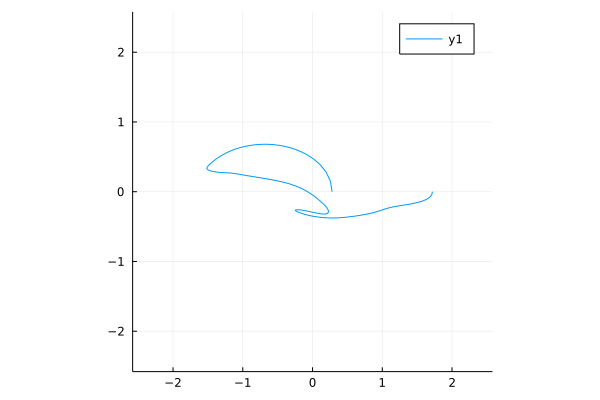

In [213]:
X,U = unpackZ(z_sol)
plot(X[1, :], X[2, :], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.5,semiMajorAxis_goal*1.5))

### DIRCOL Algorithm

In [ ]:
# TASK: Complete implement DIRCOL Algo



### Forward Pass

In [ ]:
# TASK: Complete forward simulation of satelite 

## Part (b): Simple trajectory 
Planar example with quibit interpolation and no Thurst conditions

In [ ]:
# Task Solve Simple Trajectory

In [ ]:
# vis = Visualizer()
# set_mesh!(vis, model)
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xline)

## Part (c): Higher Order DIRCOL
Solve the simple planar problem with unconstrained thrust with higher order DIRCOL 3->8th order

In [ ]:
# TASK: Implement the following method

In [ ]:
# TASK: Plot the comparison


## Part (d): Inequality Constraints 
Using the thruster constraints solve the optimization problem

In [ ]:
# TASK: Inequality constraints

In [ ]:
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xflip)

## Part (e): Non-Planar Satellite Control


In [ ]:
# TASK: Non-Planar Control

## TESTS

In [ ]:
# run_tests();